In [65]:
from pathlib import Path
from shutil import copy2 as copy

In [19]:
from tqdm import tqdm
import cv2
import numpy as np
import pandas as pd

In [74]:
import json

In [76]:
!pwd

/home/jiun/workspace/detector/labs


In [75]:
with open('amano-nvr-parking.json') as f:
    context = json.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'amano-nvr-parking.json'

In [20]:
images = sorted(Path('/home/jiun/datasets/amano/nvr-warp/train/images').glob('*.jpg'))
groundtruths = sorted(Path('/home/jiun/datasets/amano/nvr-warp/train/annotations').glob('*.txt'))

In [22]:
dataset = {}
canvas = {}
for image, gt in tqdm(zip(images, groundtruths), total=len(images)):
    flag = image.stem.split('_CT_')[0]
    
    if canvas.get(flag, None) is None:
        canvas[flag] = cv2.imread(str(image))
    
    try:
        g = pd.read_csv(str(gt), header=None).values
    except:
        g = np.empty((0, 4), dtype=np.int64)
    
    boxes = dataset.get(flag, np.empty((0, 4), dtype=np.int64))
    dataset[flag] = np.concatenate((boxes, g))

100%|██████████| 11818/11818 [00:50<00:00, 233.92it/s]


In [57]:
key = 'nvr001_21_21'

In [58]:
boxes, img = dataset[key], canvas[key]

In [59]:
i = img.copy()
for x, y, w, h in boxes[nms(boxes)]:
    cv2.rectangle(i, (int(x), int(y)), (int(w), int(h)), (255, 0, 0), 1)

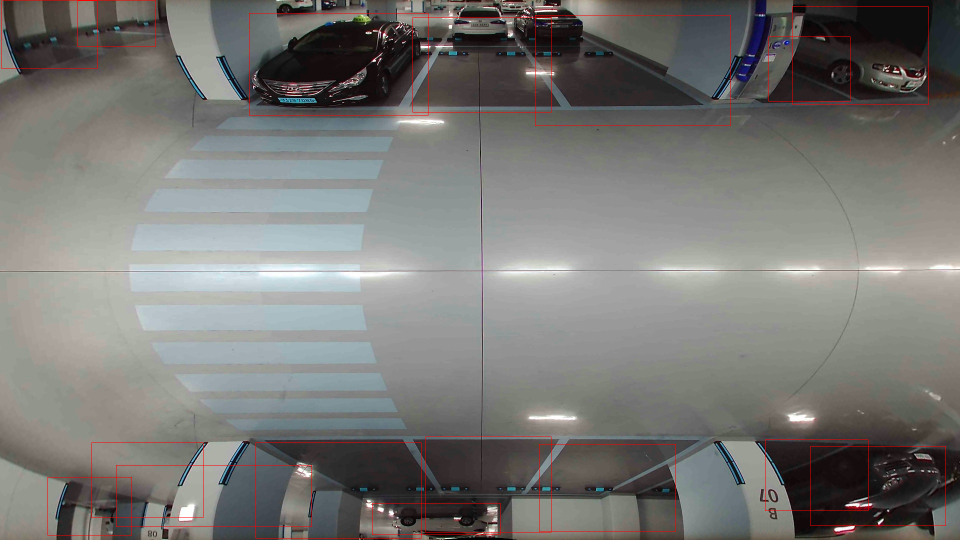

In [60]:
show(cv2.resize(i, (960, 540)))

In [25]:
from PIL import Image
from IPython.display import display

def show(ary):
    display(Image.fromarray(ary))

In [14]:
def nms(dets, scores=None, thresh=None):
    thresh = thresh or .3
    scores = scores or np.ones(np.size(dets, 0))
    
    x1 = dets[:, 0]
    y1 = dets[:, 1]
    x2 = dets[:, 2]
    y2 = dets[:, 3]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1] # get boxes with more ious first

    keep = []
    while order.size > 0:
        i = order[0] # pick maxmum iou box
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1) # maximum width
        h = np.maximum(0.0, yy2 - yy1 + 1) # maxiumum height
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= thresh)[0]
        order = order[inds + 1]

    return keep